In [1]:
import sys
import numpy as np
sys.path.append('../')

import matplotlib.pyplot as plt
import matplotlib.pylab as pylab

import requests
from io import BytesIO
from PIL import Image
import numpy as np

from maskrcnn_benchmark.config import cfg
from predictor import COCODemo


# load image and then run prediction
from PIL import Image

# this makes our figures bigger
pylab.rcParams['figure.figsize'] = 30, 16


%load_ext autoreload
%autoreload 2

config_file = "../configs/avenue_e2e_faster_rcnn_R_101_FPN_1x.yaml"

# update the config options with the config file
cfg.merge_from_file(config_file)
# manual override some options
cfg.merge_from_list(["MODEL.DEVICE", "cpu"])

coco_demo = COCODemo(
    cfg,
    min_image_size=600,
    confidence_threshold=0.7,
)

def imshow(img):
    plt.imshow(img[:, :, [2, 1, 0]])
    plt.axis("off")
    

coco_demo.CATEGORIES = ["__background", "House Number"]

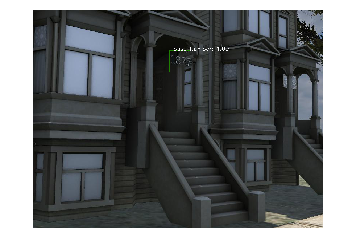

In [2]:

pil_image = Image.open('/home/jerpint/digit-detection/data/Avenue/Humanware_v1_1551895483/test/image_4043.jpg').convert("RGB")

# convert to BGR format
image = np.array(pil_image)[:, :, [2, 1, 0]]

prediction_img = coco_demo.run_on_opencv_image(image)
imshow(prediction_img)

In [3]:
predictions = coco_demo.compute_prediction(image)
best_predictions = coco_demo.select_top_predictions(predictions)

In [4]:
import torch
import torchvision
resize = torchvision.transforms.Resize((54,54), interpolation=2)

sys.path.append('/home/jerpint/digit-detection/')
digit_detector = torch.load('/home/jerpint/digit-detection/results/SVHN_Multiloss_VGG19_trainextra_2/best_model.pth', map_location='cpu')

bbox = best_predictions.bbox[0].cpu().numpy()
bbox_round = np.round(bbox).astype('int')
img_box = image[bbox_round[1]:bbox_round[3], bbox_round[0]:bbox_round[2], :]
image_box_pil = Image.fromarray(img_box.astype('uint8'), 'RGB')
resized_img = np.asarray(resize(image_box_pil))

In [5]:
sys.path.append('/home/jerpint/digit-detection/')
digit_detector = torch.load('/home/jerpint/digit-detection/results/SVHN_Multiloss_VGG19_trainextra_2/best_model.pth', map_location='cpu')



In [6]:
svhn_test = Image.open("/home/jerpint/digit-detection/data/SVHN/extra/1.png")
svhn_test = np.asarray(resize(svhn_test))

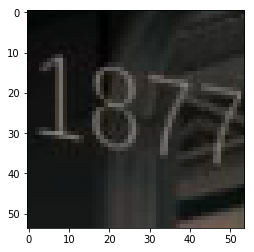

In [7]:
plt.imshow(resized_img)

In [8]:
# resized_img = np.asarray(resize(image_box_pil))

def make_prediction(resized_img):

    assert resized_img.shape == (54, 54, 3)

    images_mean = (109.7994, 110.00522, 114.33739)
    images_std = (12.675092, 12.741672, 11.369844)

    # This is likely in the wrong order
    img_normalized = (resized_img - images_mean) / images_std

    # swap color axis
    # numpy image: H x W x C
    # torch image: C X H X W
    img_normalized = img_normalized.transpose((2, 0, 1))
    img_tensor = torch.from_numpy(img_normalized).float()
    img_tensor = img_tensor[None, :, :, :]
    outputs = digit_detector.forward(img_tensor)
    batch_preds = []

    for index in range(len(outputs)):
        pred = outputs[index]


        _, predicted = torch.max(pred.data, 1)
        batch_preds.append(predicted)
    return batch_preds

In [9]:
batch_preds = make_prediction(resized_img)
batch_preds

[tensor([4]), tensor([1]), tensor([8]), tensor([7]), tensor([7]), tensor([7])]